#### Start

In [1]:
#!/usr/bin/env python
# coding: utf-8
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder, PowerTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.experimental import enable_iterative_imputer
import gc
import pickle
import warnings
from collections import defaultdict

# try:
#     ray.init()
# except:
#     pass
# import modin.pandas as pd
# from data_handling import get_info
import numpy as np
import pandas as pd
from dask.dataframe import from_pandas
from dask.distributed import Client
from joblib import parallel_backend
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import (
    AdaBoostRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    StackingRegressor,
)
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import (
    ARDRegression,
    BayesianRidge,
    ElasticNet,
    LarsCV,
    Lasso,
    LassoCV,
    LassoLars,
    LassoLarsIC,
    RANSACRegressor,
    RidgeCV,
    TweedieRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearnex import patch_sklearn
from tqdm import tqdm

# import ray

pd.options.display.max_columns = 90
pd.options.display.max_rows = 90
warnings.filterwarnings("ignore")
set_config(display="diagram")
dirty_results = defaultdict(dict)
reference_metadata = defaultdict(dict)
clean_results = defaultdict(dict)

patch_sklearn()
iter_ = 10000
tol = 0.000001


def gen_stack():
    modis = [
        make_pipeline(
            LassoLarsIC(normalize=False, precompute=True, criterion="bic")),
        make_pipeline(
            RANSACRegressor(
                min_samples=500,
                base_estimator=ARDRegression(),
                max_trials=1000,
            ), ),
        make_pipeline(ElasticNet(precompute=True, ), ),
        make_pipeline(Lasso(precompute=True, max_iter=iter_, tol=tol)),
        make_pipeline(LassoLars(precompute=True, max_iter=iter_)),
        # make_pipeline(LassoCV(precompute=True, n_jobs=-1, cv=5, tol=tol)),
        # make_pipeline(TweedieRegressor(power=0)),
        # make_pipeline(HistGradientBoostingRegressor(max_iter=1000, max_depth=50)),
        # make_pipeline(
        #     GradientBoostingRegressor(
        #         learning_rate=0.0001,
        #         n_estimators=3000,
        #         subsample=0.8,
        #         init=ElasticNet(precompute=True),
        #         validation_fraction=0.2,
        #         n_iter_no_change=30,
        #         random_state=0,
        #         max_depth=30,
        #     ),
        # ),
        # make_pipeline(DecisionTreeRegressor()),
        # make_pipeline(
        #     ExtraTreesRegressor(
        #         n_jobs=-1,
        #         bootstrap=True,
        #         n_estimators=50,
        #         random_state=0,
        #     ),
        # ),
        # make_pipeline(
        #     AdaBoostRegressor(
        #         base_estimator=Lasso(precompute=True), n_estimators=30, random_state=0, loss="exponential"
        #     ),
        # ),
    ]

    # numerical_selector = make_column_selector(dtype_include=np.float32)
    # sel = SelectFromModel(estimator=GradientBoostingRegressor(
    #             learning_rate=0.0001,
    #             n_estimators=3000,
    #             subsample=0.8,
    #             init=ElasticNet(precompute=True),
    #             validation_fraction=0.2,
    #             n_iter_no_change=30,
    #             random_state=0,
    #             max_depth=30,
    #         ), threshold="median")
    # numeric_scaler = StandardScaler()
    # tree_prep = ColumnTransformer(transformers=[("num", numeric_scaler, numerical_selector)], remainder="passthrough")
    # lasso_linear_prep = ColumnTransformer(transformers=[("num", numeric_scaler, numerical_selector)])
    # # modis = []
    stacked_estimators = []
    for q in modis:
        estimator_name = q[0].__class__.__name__
        stacked_estimators.append((estimator_name, q))
    estimator_stack = StackingRegressor(
        estimators=stacked_estimators,
        cv=2,
        n_jobs=-1,
        final_estimator=HistGradientBoostingRegressor())
    # learning_stack = make_pipeline(tree_prep, sel, estimator_stack)

    return estimator_stack


# gen_stack(modis)


def save_pipeline(c, p):
    with open(f"stacking_models/stack_{c}.pkl", "wb+") as file_output:
        pickle.dump(p, file_output)


def get_data_feed(c, x_y):
    training_features = x_y.drop([c], axis=1)
    y = x_y[c]
    x_temp_train, x_temp_test, y_temp_train, y_temp_train = train_test_split(
        training_features, y, test_size=0.3, random_state=0)
    return x_temp_train, x_temp_test, y_temp_train, y_temp_train


training_targets = [
    "F_1_0",
    "F_1_1",
    "F_1_2",
    "F_1_3",
    "F_1_4",
    "F_1_5",
    "F_1_6",
    "F_1_7",
    "F_1_8",
    "F_1_9",
    "F_1_10",
    "F_1_11",
    "F_1_12",
    "F_1_13",
    "F_1_14",
    "F_3_0",
    "F_3_1",
    "F_3_2",
    "F_3_3",
    "F_3_4",
    "F_3_5",
    "F_3_6",
    "F_3_7",
    "F_3_8",
    "F_3_9",
    "F_3_10",
    "F_3_11",
    "F_3_12",
    "F_3_13",
    "F_3_14",
    "F_3_15",
    "F_3_16",
    "F_3_17",
    "F_3_18",
    "F_3_19",
    "F_3_20",
    "F_3_21",
    "F_3_22",
    "F_3_23",
    "F_3_24",
    "F_4_0",
    "F_4_1",
    "F_4_2",
    "F_4_3",
    "F_4_4",
    "F_4_5",
    "F_4_6",
    "F_4_7",
    "F_4_8",
    "F_4_9",
    "F_4_10",
    "F_4_11",
    "F_4_12",
    "F_4_13",
    "F_4_14",
]


def gen_sparse_data(dpkl) -> pd.DataFrame:
    cats = [x for x in dpkl.columns if "F_2" in x]
    # for c in cats:
    #     dpkl = feature_one_hot(c)
    spar = pd.DataFrame()
    cat_pd = dpkl.loc[:, cats].copy()

    for fi in cats:
        new_n = fi.replace("_", "") + "_"
        f_one_hot = pd.get_dummies(dpkl[fi], prefix=new_n)
        spar_ = f_one_hot.astype(pd.SparseDtype(np.uint8, fill_value=0))
        for c in spar_.columns:
            spar[c] = spar_[c]
    dpkl = dpkl.drop(cats, axis=1)
    for c in spar.columns:
        dpkl[c] = spar[c]
    return dpkl


if __name__ == "__main__":
    cli = Client(processes=False)

    def run(dataset_db):
        # global modis
        numerical_selector = make_column_selector(dtype_include=np.float32)
        sel = SelectFromModel(estimator=RandomForestRegressor(n_jobs=-1,
                                                              n_estimators=30),
                              threshold="median")
        numeric_scaler = StandardScaler()
        tree_prep = ColumnTransformer(transformers=[("num", numeric_scaler,
                                                     numerical_selector)],
                                      remainder="passthrough")
        trd = dataset_db[dataset_db.missing_cols == 0].copy()
        x_y = trd.drop(["missing_cols"], axis=1)
        with parallel_backend("dask"):
            for cl in tqdm(training_targets):
                training_features = x_y.drop([cl], axis=1)
                y = x_y[cl]
                x_train, x_test, y_train, y_test = train_test_split(
                    training_features, y, test_size=0.3, random_state=0)
                t = make_pipeline(tree_prep, sel)
                x_train_t = t.fit_transform(x_train, y_train)
                new_stack = gen_stack()
                new_stack.fit(x_train_t, y_train)
                yp = new_stack.predict(t.transform(x_test))
                with open("results_mod", "a") as fp:
                    fp.write(f"{cl} : {mean_squared_error(yp, y_test)}\n\n")
                print(
                    f" mean_squared_error {cl} : {mean_squared_error(yp, y_test)}\n\n"
                )
                save_pipeline(cl, new_stack)


"""
#     dataset = pd.read_pickle("cooked_sparsely.pkl")
#   with parallel_backend("loky", n_jobs=-1):
#     run(dataset)


## Preparing Data for DevCloud

# STORAGE="../data"
# df = pd.read_csv(STORAGE+'/data.csv', index_col=0)

# import pandas as pd
# import pickle
# # data = pd.read_csv("data/data.csv", index_col=0)
# data = df.copy()
# int64_cols = data.select_dtypes("int64")
# for c in int64_cols:
#     data[c] = data[c].astype("category")

# fl16_cols = data.select_dtypes(include="float64")

# for c in fl16_cols:
#     data[c] = data[c].astype(np.float32)

# na_mat = data.isna()

# miss_row = na_mat.sum(axis=1)

# data["missing_cols"] = miss_row
# data.to_pickle('cooked.pkl')
"""

data = pd.read_pickle('cooked.pkl')

gen_stack()

# def run(dataset_db):
# global modis
enable = 0
if enable == 1:
    numerical_selector = make_column_selector(dtype_include=np.float32)
    sel = SelectFromModel(estimator=RandomForestRegressor(n_jobs=-1,
                                                          n_estimators=30),
                          threshold="median")
    numeric_scaler = StandardScaler()
    tree_prep = ColumnTransformer(transformers=[("num", numeric_scaler,
                                                 numerical_selector)],
                                  remainder="passthrough")
    trd = dataset_db[dataset_db.missing_cols == 0].copy()
    x_y = trd.drop(["missing_cols"], axis=1)
    with parallel_backend("dask"):
        for cl in tqdm(training_targets):
            training_features = x_y.drop([cl], axis=1)
            y = x_y[cl]
            x_train, x_test, y_train, y_test = train_test_split(
                training_features, y, test_size=0.3, random_state=0)
            t = make_pipeline(tree_prep, sel)
            x_train_t = t.fit_transform(x_train, y_train)
            new_stack = gen_stack()
            new_stack.fit(x_train_t, y_train)
            yp = new_stack.predict(t.transform(x_test))
            with open("results_mod", "a") as fp:
                fp.write(f"{cl} : {mean_squared_error(yp, y_test)}\n\n")
            print(
                f" mean_squared_error {cl} : {mean_squared_error(yp, y_test)}\n\n"
            )
            save_pipeline(cl, new_stack)

dirty = data[data.missing_cols > 1]
clean = data[data.missing_cols == 0]

available_targets = dirty.isna().sum(axis=0)
training_targets = available_targets[available_targets > 1].index

training_targets = [
    'F_1_0', 'F_1_1', 'F_1_2', 'F_1_3', 'F_1_4', 'F_1_5', 'F_1_6', 'F_1_7',
    'F_1_8', 'F_1_9', 'F_1_10', 'F_1_11', 'F_1_12', 'F_1_13', 'F_1_14',
    'F_3_0', 'F_3_1', 'F_3_2', 'F_3_3', 'F_3_4', 'F_3_5', 'F_3_6', 'F_3_7',
    'F_3_8', 'F_3_9', 'F_3_10', 'F_3_11', 'F_3_12', 'F_3_13', 'F_3_14',
    'F_3_15', 'F_3_16', 'F_3_17', 'F_3_18', 'F_3_19', 'F_3_20', 'F_3_21',
    'F_3_22', 'F_3_23', 'F_3_24', 'F_4_0', 'F_4_1', 'F_4_2', 'F_4_3', 'F_4_4',
    'F_4_5', 'F_4_6', 'F_4_7', 'F_4_8', 'F_4_9', 'F_4_10', 'F_4_11', 'F_4_12',
    'F_4_13', 'F_4_14'
]

category_targets = [
    'F_2_0', 'F_2_1', 'F_2_2', 'F_2_3', 'F_2_4', 'F_2_5', 'F_2_6', 'F_2_7',
    'F_2_8', 'F_2_9', 'F_2_10', 'F_2_11', 'F_2_12', 'F_2_13', 'F_2_14',
    'F_2_15', 'F_2_16', 'F_2_17', 'F_2_18', 'F_2_19', 'F_2_20', 'F_2_21',
    'F_2_22', 'F_2_23', 'F_2_24'
]

num_targets = training_targets

model = HistGradientBoostingRegressor(loss='squared_error', learning_rate=0)

params = {
    'loss': ['squared_error', 'absolute_error'],
    'learning_rate': [0.1**i for i in range(1, 5)],  # 4
    'max_iter': [10**i for i in range(1, 6)],
    'max_leaf_nodes': None,
    'min_samples_leaf': np.linspace(10, 80, num=20, dtype=np.uint8),
    #  'l2_regularization': 0.0,
    'max_bins': 255,
    'categorical_features': None,
    'monotonic_cst': None,
    'warm_start': False,
    'early_stopping': 'auto',
    'scoring': 'loss',
    'validation_fraction': 0.1,
    'n_iter_no_change': 10,
    'tol': 1e-07,
    'verbose': 0,
    'random_state': None
}

# HistGradientBoostingRegressor?

# IterativeImputer?

payload = data[data.missing_cols == 0].copy()
payload.shape
payload.drop(['missing_cols'], axis=1, inplace=True)

# sample = RandomForestRegressor(n_estimators=30,n_jobs=-1,random_state=0)
sample = ElasticNet(precompute=True, )

print("Loaded")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Loaded


<p>
 <b>Column : F_3_16</b><br>
   <b>SelectKBest(mutual_info_regression, k=35)</b><br>
    with StandardScaler()<br><br>
</p>

In [34]:
f_select

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num',
                                                  QuantileTransformer(n_quantiles=10000,
                                                                      output_distribution='normal'),
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f71901c4e20>)])),
                ('selectfrommodel',
                 SelectFromModel(estimator=DecisionTreeRegressor(random_state=0),
                                 norm_order=3, threshold='mean'))])

```
array(['x1', 'x3', 'x18', 'x23', 'x26', 'x31', 'x37', 'x38', 'x45', 'x46',
       'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62',
       'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71',
       'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78'], dtype=object)
```

In [2]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
x_y = data[data.missing_cols == 0].copy()
x_y = x_y.drop(['missing_cols'], axis=1)
with parallel_backend('dask'):
    # #     for cl in tqdm(training_targets):
    training_features = x_y.drop(['F_4_13'], axis=1)
    y = x_y['F_4_13']
    sel = SelectKBest(mutual_info_regression, k=35)
    sel_ = SelectFromModel(estimator=DecisionTreeRegressor(random_state=0),
                           threshold='mean',
                           norm_order=3)
    tree_prep_num = ColumnTransformer(
        transformers=[("num",
                       QuantileTransformer(n_quantiles=10000,
                                           output_distribution='normal'),
                       StandardScaler(with_std=True),
                       make_column_selector(dtype_include=np.float32))],
        remainder='passthrough',
        n_jobs=-1,
    )
    # #     tree_prep_cat = ColumnTransformer([('cat', OneHotEncoder(drop=None,dtype=np.uint8),category_targets)],remainder='drop',n_jobs=-1)
    # #     uni = FeatureUnion([('num',tree_prep_num),('cat',tree_prep_cat)], )
    #     #     x_y_t=uni.fit_transform(training_features)
    f_select = make_pipeline(tree_prep_num, sel_)
# #     x_y_t = f_select.fit_transform(x_y,y)
#     AX = f_select.fit_transform(training_features,y)
#     AX = sel.fit_transform(training_features, y)

## Compare ML Models on the input sample size and performance

In [2]:
# smf = f_select[1]
import warnings
from sklearn.feature_selection import SelectKBest, mutual_info_regression

x_y = data[data.missing_cols == 0].copy()
x_y = x_y.drop(['missing_cols'], axis=1)

col = "F_1_11"
training_features = x_y.drop([col], axis=1)
y = x_y[col]
with parallel_backend("dask"):
    tree_prep_num_quantile = ColumnTransformer(
        transformers=[(
            "num",
            QuantileTransformer(n_quantiles=10000,
                                output_distribution="normal"),
            make_column_selector(dtype_include=np.float32),
        )],
        remainder=OneHotEncoder(dtype=np.uint8),
        n_jobs=-1,
    )
    tree_prep_num_standard = ColumnTransformer(
        transformers=[("num", StandardScaler(with_std=True),
                       make_column_selector(dtype_include=np.float32))],
        remainder="passthrough",
        n_jobs=-1,
    )
    tree_prep_num_power = ColumnTransformer(
        transformers=[(
            "num",
            PowerTransformer(),
            #                 StandardScaler(with_std=True),
            make_column_selector(dtype_include=np.float32),
        )],
        remainder=OneHotEncoder(dtype=np.uint8),
        n_jobs=-1,
    )

warnings.filterwarnings("ignore")

# temps = tree_prep_num_quantile.fit_transform(training_features, y)

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import seaborn as sns
from sklearn.metrics import make_scorer, r2_score, mean_absolute_percentage_error

sns.set_theme(context='notebook')
# mean_squared_error(squared=False)
mse = make_scorer(
    mean_squared_error,
    greater_is_better=False,
)
train_sizes_ = np.linspace(0.2, 0.9, 8)
cv_ = 5


def plot_learning_curve(estimator, X, y, cv=cv_, train_sizes=train_sizes_):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    axes = None
    ylim = None
    n_jobs = -1
    title = 'Learning Curve'
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        scoring=mse,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        #         exploit_incremental_learning=True
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(train_sizes,
                 train_scores_mean,
                 "o-",
                 color="r",
                 label="Training score")
    axes[0].plot(train_sizes,
                 test_scores_mean,
                 "o-",
                 color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [36]:
HistGradientBoostingRegressor?

In [44]:
categorical_features = np.array([54, 55, 56, 57, 58, 59, 60, 61, 62,
                                63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78])
mse = make_scorer(mean_squared_error, greater_is_better=False,)

params = {'loss': 'squared_error',
          'learning_rate': 0.1,
          'max_iter': 100,
          'max_leaf_nodes': 31,
          'max_depth': None,
          'min_samples_leaf': 20,
          'l2_regularization': 0.0,
          'max_bins': 255,
          'categorical_features': categorical_features,
          'monotonic_cst': None,
          'warm_start': False,
          'early_stopping': 'auto',
          'scoring': mse,
          'validation_fraction': 0.1,
          'n_iter_no_change': 10,
          'tol': 1e-07,
          'verbose': 0,
          'random_state': 42}

from sklearnex.linear_model import ElasticNet, Ridge
from sklearn.linear_model import SGDRegressor, LassoLarsCV

with parallel_backend('loky'):
    plot_learning_curve(LassoLarsIC(
        precompute=True, normalize=False), temps.toarray(), y)

with parallel_backend('loky'):
    plot_learning_curve(
        LarsCV(precompute=True, cv=5, normalize=False), temps.toarray(), y)

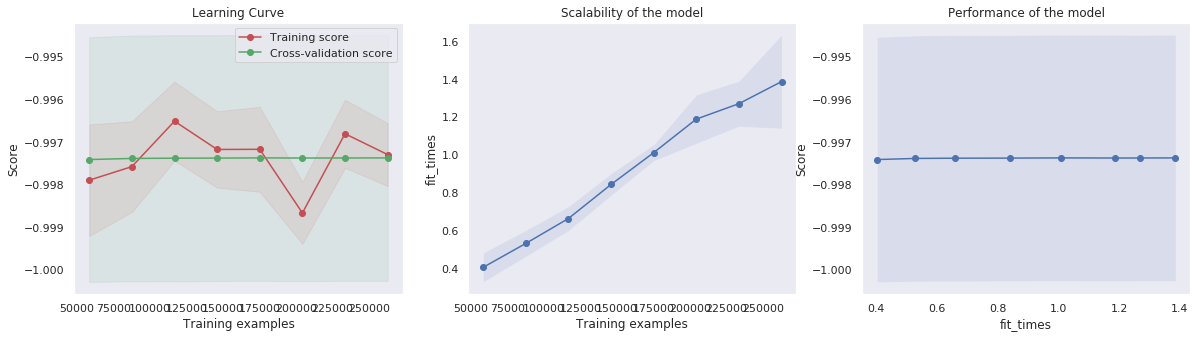

In [14]:
from sklearnex.linear_model import ElasticNet, Ridge
from sklearn.linear_model import SGDRegressor, LassoLarsCV

with parallel_backend('loky'):
    plot_learning_curve(ElasticNet(precompute=True), temps, y)

ERROR! Session/line number was not unique in database. History logging moved to new session 157


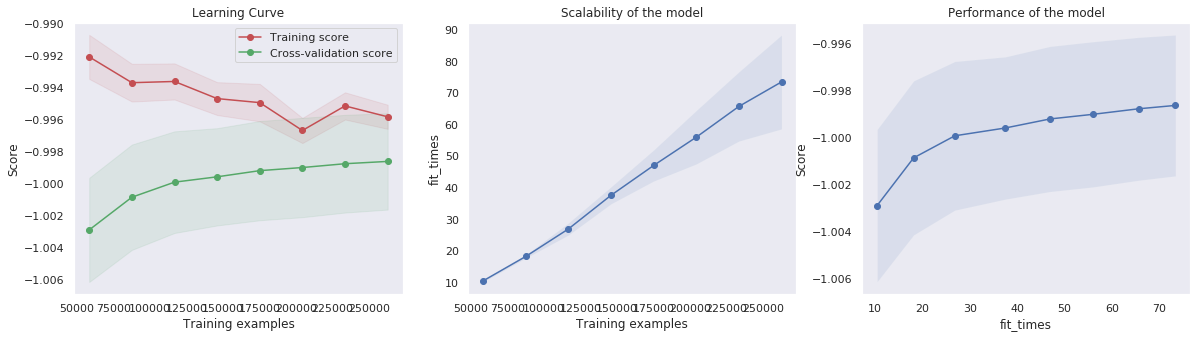

In [15]:
from sklearnex.linear_model import ElasticNet, Ridge
from sklearn.linear_model import SGDRegressor, LassoLarsCV, RidgeCV

with parallel_backend('loky'):
    plot_learning_curve(Ridge(), temps, y)

In [ ]:
from sklearnex.linear_model import ElasticNet, Ridge
from sklearn.linear_model import SGDRegressor, LassoLarsCV, RidgeCV

with parallel_backend('loky'):
    plot_learning_curve(RidgeCV(alpha_per_target=True), temps, y)

In [103]:
LarsCV?

In [18]:
e = Ridge()

In [20]:
from sklearn.model_selection import cross_validate
with parallel_backend('loky'):
    scores = cross_validate(e, temps,y,cv=10,n_jobs=-1, return_train_score=True,)


In [21]:
scores

{'fit_time': array([ 96.76445842,  91.9638648 , 100.07475781,  97.819484  ,
         98.79004693,  80.11968303,  80.00316429,  97.05492949,
        100.97967148,  93.26911139]),
 'score_time': array([0.01161909, 0.01277351, 0.00824785, 0.00912952, 0.00859714,
        0.0137825 , 0.01457596, 0.01030898, 0.00825715, 0.01242924]),
 'test_score': array([-0.00146349, -0.0011494 , -0.00113807, -0.00091264, -0.00030425,
        -0.00039823, -0.00042943, -0.00181561, -0.0015261 , -0.00097456]),
 'train_score': array([0.00122207, 0.00118131, 0.00119475, 0.00119153, 0.0011207 ,
        0.00112166, 0.00111477, 0.0012847 , 0.00123616, 0.00116589])}

In [3]:
# smf = f_select[1]
import warnings
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearnex.linear_model import Ridge
x_y = data[data.missing_cols == 0].copy()
x_y = x_y.drop(['missing_cols'], axis=1)

col = "F_1_0"
training_features = x_y.drop([col], axis=1)
y = x_y[col]
with parallel_backend("dask"):
    tree_prep_num_quantile = ColumnTransformer(
        transformers=[(
            "num",
            QuantileTransformer(n_quantiles=10000,
                                output_distribution="normal"),
            make_column_selector(dtype_include=np.float32),
        )],
        remainder=OneHotEncoder(dtype=np.uint8),
        n_jobs=-1,
    )
    tree_prep_num_standard = ColumnTransformer(
        transformers=[("num", StandardScaler(with_std=True),
                       make_column_selector(dtype_include=np.float32))],
        remainder="passthrough",
        n_jobs=-1,
    )
    tree_prep_num_power = ColumnTransformer(
        transformers=[(
            "num",
            PowerTransformer(),
            #                 StandardScaler(with_std=True),
            make_column_selector(dtype_include=np.float32),
        )],
        remainder=OneHotEncoder(dtype=np.uint8),
        n_jobs=-1,
    )

warnings.filterwarnings("ignore")

# temps = tree_prep_num_quantile.fit_transform(training_features, y)

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import seaborn as sns
from sklearn.metrics import make_scorer, r2_score, mean_absolute_percentage_error

sns.set_theme(context='notebook')
# mean_squared_error(squared=False)
mse = make_scorer(
    mean_squared_error,
    greater_is_better=False,
)
train_sizes_ = np.linspace(0.2, 0.9, 8)
cv_ = 5
ridge_conf = {'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}
e = Ridge(**ridge_conf)
ecv = RidgeCV(scoring=mse)
def plot_learning_curve(estimator, X, y, cv=cv_, train_sizes=train_sizes_):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    axes = None
    ylim = None
    n_jobs = -1
    title = 'Learning Curve'
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        scoring=mse,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        #         exploit_incremental_learning=True
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(train_sizes,
                 train_scores_mean,
                 "o-",
                 color="r",
                 label="Training score")
    axes[0].plot(train_sizes,
                 test_scores_mean,
                 "o-",
                 color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt
# with parallel_backend('loky'):
#     scores = cross_validate(e, temps,y,cv=10,n_jobs=-1, return_train_score=True,scoring=mse)

In [39]:
with parallel_backend('loky'):
    scores = cross_validate(e, temps,y,cv=10,n_jobs=-1, return_train_score=True,scoring=mse)

In [43]:
scores_cv = {'fit_time': np.array([95.44586062, 66.0003469 , 90.37744975, 89.78104258, 65.31634521,
        96.24802971, 95.96836829, 88.32871366, 88.22908282, 93.77500725]),
 'score_time': np.array([0.00831008, 0.01333785, 0.01002216, 0.0113132 , 0.01413941,
        0.00786495, 0.00802422, 0.01254869, 0.01291633, 0.0088954 ]),
 'test_score': np.array([-0.99187887, -1.01943219, -1.01126456, -1.00257528, -0.99743867,
        -1.00767112, -1.00398886, -1.0135107 , -1.00098562, -0.99631822]),
 'train_score': np.array([-1.00381446, -1.00073624, -1.00163186, -1.00261211, -1.00317049,
        -1.00207114, -1.0024823 , -1.0013994 , -1.00278139, -1.00329638])}

In [33]:
ecv.fit(temps,y)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
        scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [44]:
scores = {'fit_time': np.array([62.55667925, 92.82834125, 88.50097322, 94.77731895, 66.44953442,
        87.59022713, 86.35325146, 92.94900346, 92.86478639, 86.17717481]),
 'score_time': np.array([0.0161376 , 0.01081729, 0.0122385 , 0.0097754 , 0.01524544,
        0.01406622, 0.01359963, 0.01033878, 0.01052308, 0.01516175]),
 'test_score': np.array([-0.99188155, -1.01943266, -1.01125932, -1.00257707, -0.99743801,
        -1.00766969, -1.00398481, -1.01351058, -1.00098944, -0.99631828]),
 'train_score': np.array([-1.00381422, -1.00073612, -1.00163209, -1.00261164, -1.00317001,
        -1.00207078, -1.00248265, -1.00139904, -1.00278068, -1.0032959 ])}

In [48]:
sc_df = pd.DataFrame(scores)

In [47]:
sccv_df =  pd.DataFrame(scores_cv)

In [49]:
sccv_df-sc_df

,fit_time,score_time,test_score,train_score
0,32.889181,-0.007828,2.680000e-06,-2.400000e-07
1,-26.827994,0.002521,4.700000e-07,-1.200000e-07
2,1.876477,-0.002216,-5.240000e-06,2.300000e-07
3,-4.996276,0.001538,1.790000e-06,-4.700000e-07
4,-1.133189,-0.001106,-6.600000e-07,-4.800000e-07
5,8.657803,-0.006201,-1.430000e-06,-3.600000e-07
6,9.615117,-0.005575,-4.050000e-06,3.500000e-07
7,-4.620290,0.002210,-1.200000e-07,-3.600000e-07
8,-4.635704,0.002393,3.820000e-06,-7.100000e-07
9,7.597832,-0.006266,6.000000e-08,-4.800000e-07


In [7]:
from mlxtend.plotting import plot_linear_regression
from mlxtend.plotting import plot_learning_curves
with parallel_backend('loky'):
    X_train,X_test,y_train,y_test = train_test_split(temps,y, test_size=0.5)
#     clf=Ridge(alpha=10)
#     plot_learning_curves(X_train, y_train, X_test, y_test, clf)
    #     intercept, slope, corr_coeff = plot_linear_regression(temps, y,model=e)
#     plt.show()

In [5]:
from evalml.problem_types import ProblemTypes
from evalml.automl import AutoMLSearch
from evalml.objectives import RootMeanSquaredError as rmse

In [ ]:
AutoMLSearch(X_train=None,
             y_train=None,
             problem_type='regression',
             objective=rmse,
             max_iterations=None,
             max_time=None,
             patience=None,
             tolerance=None,
             data_splitter=None,
             allowed_component_graphs=None,
             allowed_model_families=[None],
             features=None,
             start_iteration_callback=None,
             add_result_callback=None,
             error_callback=None,
             additional_objectives=None,
             alternate_thresholding_objective='F1',
             random_seed=0,
             n_jobs=-1,
             tuner_class=None,
             optimize_thresholds=True,
             ensembling=False,
             max_batches=None,
             problem_configuration=None,
             train_best_pipeline=True,
             search_parameters=None,
             sampler_method='auto',
             sampler_balanced_ratio=0.25,
             allow_long_running_models=False,
             _ensembling_split_size=0.2,
             _pipelines_per_batch=5,
             automl_algorithm='default',
             engine='sequential',
             verbose=False)

In [1]:
import modin.pandas as pd

In [2]:
data = pd.read_pickle('cooked.pkl')

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

To request implementation, send an email to feature_requests@modin.org.


In [6]:
data

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14,missing_cols
row_id,,,,,,,,,,,,,,,,,,,,,
0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,-0.500665,...,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055,2
1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,-0.363425,...,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775,1
2,0.256023,-1.059874,NaN,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,0.595777,...,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576,2
3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,-2.217847,...,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152,1
4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,-1.143500,...,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-0.823740,0.285673,0.343307,-0.436747,1.700549,-1.069432,0.819698,-0.168457,-0.429074,0.844075,...,-0.301352,5.339675,-0.991529,1.279494,-0.841051,-2.276500,1.762961,5.324553,-0.228733,0
999996,-0.769106,-0.387363,-1.227469,0.601183,0.351161,0.219475,-0.530277,0.853452,0.608646,1.648023,...,-1.299360,-0.071713,-0.162173,0.072501,-0.614687,-1.265524,0.190385,-0.344112,-0.346807,0
999997,0.147534,-0.715276,-0.465049,-1.988941,-1.594535,-1.044882,3.159455,-0.634108,0.890382,-1.212444,...,3.105002,-3.470520,NaN,0.096988,0.569255,3.609790,-0.584108,-1.492096,-0.997502,2
